## FC-VAE multi-modal anomaly detector

An unsupervised model for detecting anomaly whenever a deviation is found in comparison to normal behavior. FC-VAE does multimodal data fusion by combining sensor feature data over time. A learnable threshold is used to decide on anomalous behavior. In the case of MHHD the sensors are Apps, Key Strokes, URLs, (and potentially Voice, Camera, Registry Keys).

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import json
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import tensorflow as tf

import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers import LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.datasets import mnist

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import EarlyStopping

from keras.utils import plot_model

In [72]:
nab_path = './data/NAB'
nab_data_path = nab_path + '/data/'

labels_filename = '/labels/combined_labels.json'
train_file_name = 'artificialNoAnomaly/art_daily_no_noise.csv' 
test_file_name = 'artificialWithAnomaly/art_daily_jumpsup.csv'

#train_file_name = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'
#test_file_name = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

labels_file = open(nab_path + labels_filename, 'r')
labels = json.loads(labels_file.read())
labels_file.close()

def load_data_frame_with_labels(file_name):
    data_frame = pd.read_csv(nab_data_path + file_name)
    data_frame['anomaly_label'] = data_frame['timestamp'].isin(
        labels[file_name]).astype(int)
    return data_frame

train_data_frame = load_data_frame_with_labels(train_file_name)
test_data_frame = load_data_frame_with_labels(test_file_name)

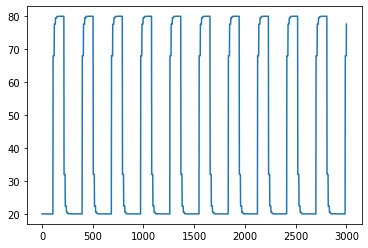

In [73]:
plt.plot(train_data_frame.loc[0:3000,'value'])

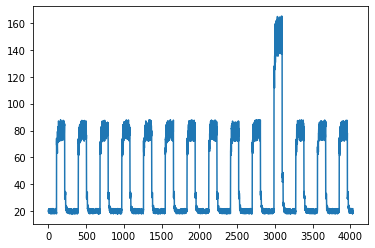

In [74]:
plt.plot(test_data_frame['value'])

In [75]:
train_data_frame_final = train_data_frame.loc[0:3000,:]
test_data_frame_final = test_data_frame

In [76]:
data_scaler = StandardScaler()
data_scaler.fit(train_data_frame_final[['value']].values)
train_data = data_scaler.transform(train_data_frame_final[['value']].values)
test_data = data_scaler.transform(test_data_frame_final[['value']].values)                                                      

In [77]:
DATA_PATH = './data/'

def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 16
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [78]:
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),:])
        dataY.append(dataset[i+look_back,:])

    return np.array(dataX), np.array(dataY)

In [79]:
X_data, y_data = create_dataset(train_data, look_back=64) #look_back = window_size
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
X_test, y_test = create_dataset(test_data, look_back=64)  #look_back = window_size

In [80]:
X_train_flatten = np.reshape(X_train, (X_train.shape[0], np.prod(X_train.shape[1:])))
X_test_flatten = np.reshape(X_test, (X_test.shape[0], np.prod(X_test.shape[1:])))

In [81]:
#training params
batch_size = 128
num_epochs = 64 

#model params
original_dim = np.prod(X_train.shape[1:]) #64
#timesteps = X_train.shape[1]
#input_dim = X_train.shape[-1]
intermediate_dim = 16 #256
latent_dim = 2
epsilon_std = 1.0

In [82]:
#sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [83]:
#likelihood layer
def likelihood(args):
    x, x_decoded_mean, x_decoded_scale = args
    dist = tf.contrib.distributions.MultivariateNormalDiag(x_decoded_mean, x_decoded_scale)
    likelihood = dist.log_prob(x)  
    return likelihood

In [84]:
#VAE architecture

#encoder
x = Input(shape=(original_dim,))
h1 = Dense(intermediate_dim, activation='relu')(x)
h2 = Dense(intermediate_dim, activation='relu')(h1)
z_mean = Dense(latent_dim)(h2)
z_log_sigma = Dense(latent_dim, activation='softplus')(h2)

#sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#decoder
decoder_h1 = Dense(intermediate_dim, activation='relu')
decoder_h2 = Dense(intermediate_dim, activation='relu')

decoder_loc = Dense(original_dim)
decoder_scale = Dense(original_dim, activation='softplus')

h_decoded1 = decoder_h1(z)
h_decoded2 = decoder_h2(h_decoded1)
x_decoded_mean = decoder_loc(h_decoded2)
x_decoded_scale = decoder_scale(h_decoded2)

like = Lambda(likelihood, output_shape=(original_dim,))([x, x_decoded_mean, x_decoded_scale])

In [85]:
#custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    
    def vae_loss(self, x, z_mean, z_log_sigma, likelihood):        
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = -K.mean(likelihood - kl_loss)
        return loss

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_sigma = inputs[2]
        likelihood = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_sigma, likelihood)
        self.add_loss(loss, inputs=inputs)
        return x

In [86]:
y = CustomVariationalLayer()([x, z_mean, z_log_sigma, like])
vae_like = Model(x, like)
vae = Model(x, y)

In [87]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae.compile(loss=None, optimizer=adam, metrics=['accuracy'])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           1040        input_2[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 16)           272         dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2)            34          dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (

In [88]:
#define callbacks
file_name = DATA_PATH + 'fc-vae-weights-checkpoint.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=64, verbose=1)
callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping]

In [89]:
print("training vae model...")
hist = vae.fit(x=X_train_flatten, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_split=0.1, verbose=2)

training vae model...
Train on 2377 samples, validate on 265 samples
Epoch 1/64
 - 1s - loss: 154.5908 - val_loss: 122.0094

Epoch 00001: loss improved from inf to 154.59082, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 2/64
 - 0s - loss: 111.6414 - val_loss: 104.6944

Epoch 00002: loss improved from 154.59082 to 111.64142, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 3/64
 - 0s - loss: 103.6699 - val_loss: 101.0034

Epoch 00003: loss improved from 111.64142 to 103.66995, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 4/64
 - 0s - loss: 100.7299 - val_loss: 98.2313

Epoch 00004: loss improved from 103.66995 to 100.72995, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 5/64
 - 0s - loss: 96.9728 - val_loss: 93.7632

Epoch 00005: loss improved from 100.72995 to 96.97283, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 6/64
 - 0s - loss: 91.9909 - val_loss: 89.3096

Epoch 00006: loss improved from 96.97283 to 91.99092, sav


Epoch 00056: loss improved from -0.08268 to -1.44299, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 57/64
 - 0s - loss: -1.8662e+00 - val_loss: -1.7117e+00

Epoch 00057: loss improved from -1.44299 to -1.86623, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 58/64
 - 0s - loss: 1.7334 - val_loss: -5.7313e+00

Epoch 00058: loss did not improve from -1.86623
Epoch 59/64
 - 0s - loss: -2.1226e+00 - val_loss: -5.3763e+00

Epoch 00059: loss improved from -1.86623 to -2.12257, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 60/64
 - 0s - loss: -2.3783e+00 - val_loss: 0.2874

Epoch 00060: loss improved from -2.12257 to -2.37832, saving model to ./data/fc-vae-weights-checkpoint.hdf5
Epoch 61/64
 - 0s - loss: -2.1154e+00 - val_loss: 4.4490

Epoch 00061: loss did not improve from -2.37832
Epoch 62/64
 - 0s - loss: -3.3929e+00 - val_loss: -2.9473e+00

Epoch 00062: loss improved from -2.37832 to -3.39288, saving model to ./data/fc-vae-weights-checkpoint.hdf5


In [26]:
vae.save(DATA_PATH + 'fc-vae-final_model.h5', overwrite=True)
vae.save_weights(DATA_PATH + 'fc-vae-final_weights.h5', overwrite=True)

In [ ]:
#load saved model
#vae = load_model(DATA_PATH + 'final_model.h5')

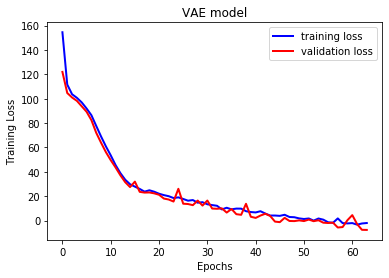

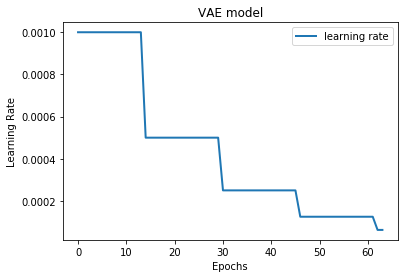

In [90]:
#generate plots

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, c='b', label='training loss')
plt.plot(hist.history['val_loss'], lw=2.0, c='r', label='validation loss')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('./figures/lstm_vae_training_loss.png')


plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('./figures/lstm_vae_learning_rate.png')

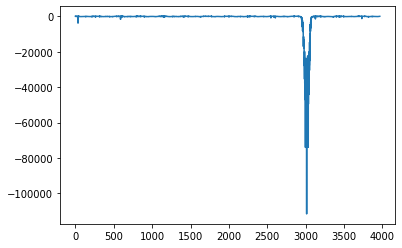

In [91]:
pred_test_flatten = vae_like.predict(X_test_flatten)
plt.plot(pred_test_flatten)

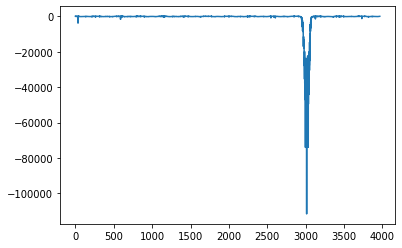

In [92]:
nan_idx = np.isnan(pred_test_flatten)
pred_test_flatten[nan_idx] = 0
plt.plot(pred_test_flatten)

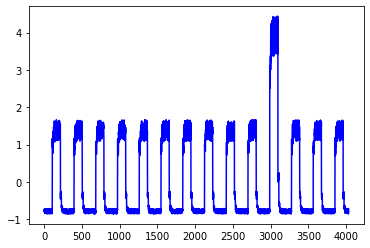

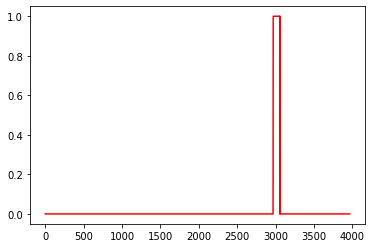

In [98]:
is_anomaly = pred_test_flatten < -1e4
plt.figure()
plt.plot(test_data, color='b')
plt.figure()
plt.plot(is_anomaly, color='r')

## References

[1] Park et al., "A Multimodal Anomaly Detector for Robot-Assisted Feeding Using an LSTM-Based Variational Autoencoder", arXiv 2018: https://arxiv.org/pdf/1711.00614.pdf  
[2] Zhang et al, "Time Series Anomaly Detection with Variational Autoencoders": https://arxiv.org/pdf/1907.01702.pdf  
[3] An et al, "Variational Autoencoder based Anomaly Detection using Reconstruction Probability": http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf  |